Install DGL

Import the necessary pacakges

In [1]:
import dgl
import numpy as np
import sklearn
import torch
import torch.nn as nn
import torch.nn.functional as F
import scipy.sparse as sp
import networkx as nx
import matplotlib.pyplot as plt


**Q2**

import the karate dataset

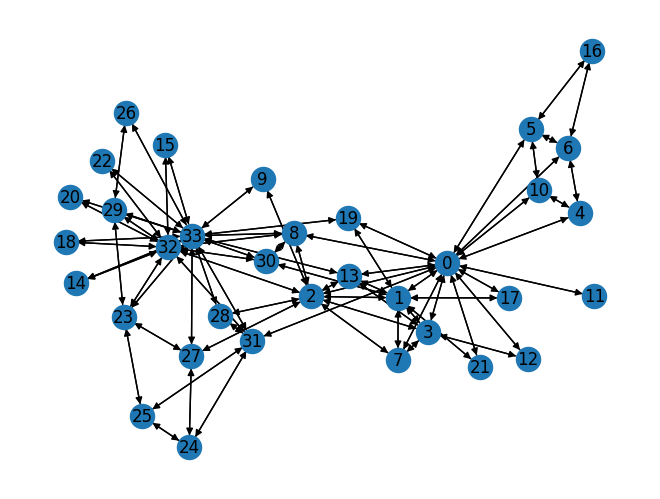

In [2]:
import dgl.data

dataset = dgl.data.KarateClubDataset()
g = dataset[0]
# type(g)
# nx.draw(g, with_labels=True)
nxg = dgl.to_networkx(g)
nx.draw(nxg, with_labels=True)

Preprocess the dataset

In [3]:
# Split edge set for training and testing
u, v = g.edges()

# Find all negative edges 
adj = sp.coo_matrix((np.ones(len(u)), (u.numpy(), v.numpy())))
adj_neg = 1 - adj.todense() - np.eye(g.number_of_nodes())
neg_u, neg_v = np.where(adj_neg != 0)

# split the postive and negative graphes
pos_g = dgl.graph(
    (u, v), num_nodes=g.number_of_nodes()
)
neg_g = dgl.graph(
    (neg_u, neg_v), num_nodes=g.number_of_nodes()
)

Initialize the node embedding

In [4]:
neg_g

Graph(num_nodes=34, num_edges=966,
      ndata_schemes={}
      edata_schemes={})

In [5]:
node_embed = nn.Embedding(g.number_of_nodes(), 2)  
inputs = node_embed.weight                         
nn.init.xavier_uniform_(inputs)

Parameter containing:
tensor([[-0.3065, -0.1053],
        [-0.3212, -0.1969],
        [-0.2145, -0.3721],
        [-0.1710, -0.0423],
        [-0.3766,  0.4012],
        [ 0.0821, -0.3276],
        [-0.2788,  0.0281],
        [ 0.2843, -0.3320],
        [-0.0604,  0.1486],
        [-0.1557, -0.1738],
        [-0.1788,  0.0874],
        [ 0.2080, -0.1677],
        [ 0.3054,  0.0459],
        [ 0.2322,  0.1624],
        [ 0.2837, -0.3889],
        [-0.1603,  0.3951],
        [-0.2109,  0.3854],
        [-0.2894, -0.2383],
        [-0.0034,  0.4038],
        [-0.0264,  0.0153],
        [-0.3219, -0.3651],
        [-0.1932, -0.0226],
        [-0.2595,  0.3029],
        [-0.0679,  0.3237],
        [ 0.3451, -0.0341],
        [-0.1882, -0.1064],
        [ 0.1971,  0.2630],
        [-0.3465,  0.2670],
        [ 0.4067,  0.1910],
        [-0.0696,  0.2086],
        [ 0.3231, -0.3503],
        [ 0.1821,  0.2508],
        [-0.2929, -0.2018],
        [-0.0495, -0.3550]], requires_grad=True)

Build the model based on  GraphSAGE.





In [6]:
from dgl.nn import SAGEConv

class Model(nn.Module):
    def __init__(self, input_feats, h_feats):
        super(Model, self).__init__()
        '''please build the two GraphSAGE layers.'''
        self.gnn1 = SAGEConv(
            in_feats = input_feats,
            out_feats = h_feats,
            activation = F.relu,
            aggregator_type = 'mean')
            
        
        self.gnn2 = SAGEConv(
            in_feats = h_feats,
            out_feats = h_feats,
            aggregator_type='mean')

    def forward(self, g, in_feat):
        hidden1 = self.gnn1(g, in_feat)
        hidden1_ar = F.relu(hidden1)
        h = self.gnn2(g, hidden1_ar)
        return h

Define the adjacency-based similarity loss

In [7]:
import dgl.function as fn


class Score(nn.Module):
    def forward(self, g, h):
        with g.local_scope():
            g.ndata['h'] = h
            # Compute a new edge feature named 'score' by a dot-product between the
            # source node feature 'h' and destination node feature 'h'.
            g.apply_edges(fn.u_dot_v('h', 'h', 'score'))
            # u_dot_v returns a 1-element vector for each edge so you need to squeeze it.
            return g.edata['score'][:, 0]

model = Model(2,2)
score = Score() 

def compute_loss(pos_score, neg_score):
    scores = torch.cat([pos_score, neg_score])
    labels = torch.cat(
        [torch.ones(pos_score.shape[0]), torch.zeros(neg_score.shape[0])]
    )
    return torch.mean((scores-labels)**2)

Train the network

In [8]:
import itertools
optimizer = torch.optim.Adam(itertools.chain(model.parameters(), node_embed.parameters()), lr=0.01)


for e in range(100):

      # forward
      h = model(g,inputs)
      pos_score = score(pos_g,h) 
      neg_score = score(neg_g,h) 
      '''please add the loss function into the training scheme'''
      loss = compute_loss(pos_score, neg_score)
      # backward
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      print("In epoch {}, loss: {}".format(e, loss))

      print()



/Users/apple/opt/anaconda3/envs/COMP4641/lib/python3.10/site-packages/dgl/backend/pytorch/tensor.py:445: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  assert input.numel() == input.storage().size(), (


In epoch 0, loss: 5.601068496704102

In epoch 1, loss: 4.212612152099609

In epoch 2, loss: 3.1436197757720947

In epoch 3, loss: 2.33404541015625

In epoch 4, loss: 1.7300441265106201

In epoch 5, loss: 1.2853442430496216

In epoch 6, loss: 0.9615092277526855

In epoch 7, loss: 0.7286290526390076

In epoch 8, loss: 0.5631318688392639

In epoch 9, loss: 0.4443543255329132

In epoch 10, loss: 0.3627285063266754

In epoch 11, loss: 0.3042217493057251

In epoch 12, loss: 0.26141324639320374

In epoch 13, loss: 0.22997641563415527

In epoch 14, loss: 0.2069179117679596

In epoch 15, loss: 0.19000065326690674

In epoch 16, loss: 0.17754746973514557

In epoch 17, loss: 0.16832366585731506

In epoch 18, loss: 0.16146220266819

In epoch 19, loss: 0.15632762014865875

In epoch 20, loss: 0.1524527221918106

In epoch 21, loss: 0.149480402469635

In epoch 22, loss: 0.14718206226825714

In epoch 23, loss: 0.14537300169467926

In epoch 24, loss: 0.14391794800758362

In epoch 25, loss: 0.142726600170

Draw the embedding

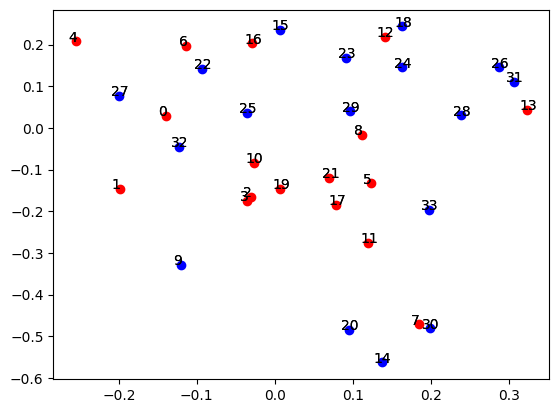

In [9]:
import matplotlib.pyplot as plt

labels = g.ndata['label'] #obtain the labels

embeddings = inputs.detach().numpy()#node_embed.weight.detach().numpy()


for ind,node in enumerate(g.nodes()):  
  if labels[ind] == 0:
    color = 'red'
  else:
    color = 'blue'
    
  '''please draw the embedding using plt.scatter()'''
  plt.scatter(embeddings[ind, 0], embeddings[ind, 1], c=color)
  plt.text(embeddings[ind, 0]-0.01, embeddings[ind, 1], str(int(node.detach().numpy())))

  plt.text(node_embed.weight.detach().numpy()[ind,0]-0.01, node_embed.weight.detach().numpy()[ind,1] , str(int(node.detach().numpy())))
plt.show()

Cluster using kmeans.

/Users/apple/opt/anaconda3/envs/COMP4641/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


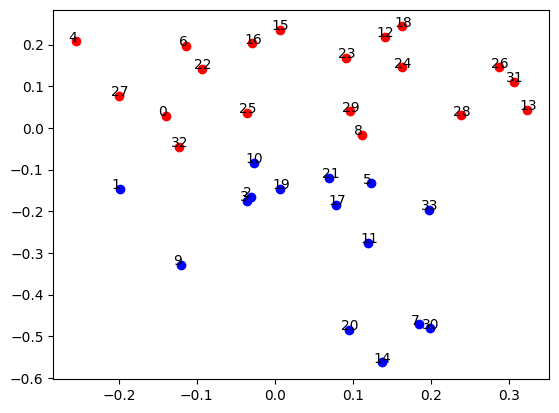

In [10]:
#Import Kmeans,networkx and matplotlib
from sklearn.cluster import KMeans
import networkx as nx
import matplotlib.pyplot as plt

'''please conduct the clustering via sklearn.cluster.Kmeans() function'''
embeddings = node_embed.weight.detach().numpy()

# Cluster using KMeans
kmeans = KMeans(n_clusters=2, random_state=0).fit(embeddings)
pred_labels = kmeans.labels_

#Visualize the embeddings

for ind,node in enumerate(g.nodes()):
  if pred_labels[ind] == 0:
    color = 'red'
  else:
    color = 'blue'
  '''please draw the embedding using plt.scatter()'''
  plt.scatter(embeddings[ind, 0], embeddings[ind, 1], c=color)
  plt.text(node_embed.weight.detach().numpy()[ind,0]-0.01, node_embed.weight.detach().numpy()[ind,1] , str(int(node.detach().numpy())))
plt.show()

# Repeat the 3 steps above, but with 3 GNN layers and 2-hop similarity function.

You can modify the codes above.


Regenerate the training data that can be combined with the 2-hop similarity function. 

In [11]:
#obtain the two hop neighbor subgraph
sg,_ = dgl.khop_in_subgraph(g, 0, k=2)


node_id_map = {}
for i,org_id in enumerate(sg.ndata[dgl.NID]):
    node_id_map[i] = int(org_id.numpy())
    

###obtain the edges in original graph, as well as the edges in two hop neighbor subgraph.
u, v = g.edges()
u_s, v_s = sg.edges()

# Map the nodes with its original ID.
for j,uu in enumerate(u_s):
    u_s[j] = torch.tensor(node_id_map[int(uu.numpy())])

for j,vv in enumerate(v_s):
    v_s[j] = torch.tensor(node_id_map[int(vv.numpy())])


# Find all negative edges 
#(positive edge means the two nodes are connected in the two hop neighbors subgraph) 
adj = sp.coo_matrix((np.ones(len(u_s)), (u_s.numpy(), v_s.numpy())))
adj_neg = 1 - adj.todense() - np.eye(g.number_of_nodes())
neg_u, neg_v = np.where(adj_neg != 0)

### build the positive and negative graph
pos_g = dgl.graph(
    (u_s, v_s), num_nodes=g.number_of_nodes()
)
neg_g = dgl.graph(
    (neg_u, neg_v), num_nodes=g.number_of_nodes()
)

Initialize the node embedding

In [12]:
node_embed = nn.Embedding(g.number_of_nodes(), 2)  
inputs = node_embed.weight                         
nn.init.xavier_uniform_(inputs)

Parameter containing:
tensor([[ 0.2468, -0.2539],
        [-0.3028,  0.1375],
        [-0.1640, -0.2028],
        [ 0.3732, -0.2603],
        [ 0.2059,  0.2353],
        [ 0.0822,  0.1053],
        [ 0.3308, -0.0078],
        [ 0.2504,  0.2605],
        [ 0.0115,  0.0701],
        [ 0.2687,  0.2682],
        [-0.0290,  0.1194],
        [ 0.2997,  0.0602],
        [-0.2691,  0.2183],
        [-0.2260,  0.1950],
        [ 0.1082,  0.1398],
        [-0.1238,  0.4030],
        [ 0.0754,  0.2795],
        [ 0.0874,  0.1623],
        [ 0.0222, -0.1102],
        [ 0.3943,  0.1628],
        [-0.0861, -0.3978],
        [-0.2026,  0.0838],
        [ 0.2927,  0.2966],
        [-0.0623, -0.2731],
        [-0.1787, -0.3978],
        [-0.0138, -0.1831],
        [-0.0162,  0.1657],
        [ 0.2782, -0.1590],
        [ 0.1209, -0.2457],
        [ 0.3193,  0.1847],
        [-0.2076,  0.0909],
        [ 0.2738, -0.0439],
        [ 0.1162, -0.1479],
        [-0.2533, -0.0999]], requires_grad=True)

Build the model based on GraphSAGE.

In [13]:
from dgl.nn import SAGEConv

class Model(nn.Module):
    def __init__(self, input_feats, h_feats):
        super(Model, self).__init__()
        '''please build the two GraphSAGE layers.'''
        self.gnn1 = SAGEConv(
            in_feats = input_feats,
            out_feats = h_feats,
            activation = F.relu,
            aggregator_type = 'mean')
            
        
        self.gnn2 = SAGEConv(
            in_feats = h_feats,
            out_feats = h_feats,
            aggregator_type='mean')
        
        self.gnn3 = SAGEConv(
            in_feats = h_feats,
            out_feats = h_feats,
            aggregator_type='mean')
        

    def forward(self, g, in_feat):
        hidden1 = self.gnn1(g, in_feat)
        hidden1_ar = F.relu(hidden1)
        hidden2 = self.gnn2(g, hidden1_ar)
        hidden2_ar = F.relu(hidden2)
        h = self.gnn3(g, hidden2_ar)
        return h

Define the two-hop similarity loss.

In [14]:
import dgl.function as fn


class Score(nn.Module):
    def forward(self, g, h):
        with g.local_scope():
            g.ndata['h'] = h
            # Compute a new edge feature named 'score' by a dot-product between the
            # source node feature 'h' and destination node feature 'h'.
            g.apply_edges(fn.u_dot_v('h', 'h', 'score'))
            # u_dot_v returns a 1-element vector for each edge so you need to squeeze it.
            return g.edata['score'][:, 0]

model = Model(2,2)
score = Score() 

def compute_loss(pos_score, neg_score):
    scores = torch.cat([pos_score, neg_score])
    labels = torch.cat(
        [torch.ones(pos_score.shape[0]), torch.zeros(neg_score.shape[0])]
    )
    return torch.mean((scores-labels)**2)

Train the network

In [15]:
import itertools
optimizer = torch.optim.Adam(itertools.chain(model.parameters(), node_embed.parameters()), lr=0.01)


for e in range(100):

      # forward
      h = model(g,inputs)
      pos_score = score(pos_g,h) 
      neg_score = score(neg_g,h) 
      '''please add the loss function into the training scheme'''
      loss = compute_loss(pos_score, neg_score)
      # backward
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      print("In epoch {}, loss: {}".format(e, loss))



/Users/apple/opt/anaconda3/envs/COMP4641/lib/python3.10/site-packages/dgl/backend/pytorch/tensor.py:445: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  assert input.numel() == input.storage().size(), (


In epoch 0, loss: 0.10160969942808151
In epoch 1, loss: 0.09681949019432068
In epoch 2, loss: 0.09505683928728104
In epoch 3, loss: 0.09441179782152176
In epoch 4, loss: 0.0941389948129654
In epoch 5, loss: 0.09400977194309235
In epoch 6, loss: 0.09398027509450912
In epoch 7, loss: 0.09400777518749237
In epoch 8, loss: 0.09405624121427536
In epoch 9, loss: 0.09409943222999573
In epoch 10, loss: 0.09412180632352829
In epoch 11, loss: 0.09411649405956268
In epoch 12, loss: 0.09408315271139145
In epoch 13, loss: 0.09402583539485931
In epoch 14, loss: 0.09395107626914978
In epoch 15, loss: 0.09386696666479111
In epoch 16, loss: 0.09378102421760559
In epoch 17, loss: 0.09370017051696777
In epoch 18, loss: 0.09363027662038803
In epoch 19, loss: 0.09357546269893646
In epoch 20, loss: 0.09353772550821304
In epoch 21, loss: 0.09351679682731628
In epoch 22, loss: 0.09351005405187607
In epoch 23, loss: 0.09351259469985962
In epoch 24, loss: 0.09351792931556702
In epoch 25, loss: 0.093519054353237


Draw the embedding

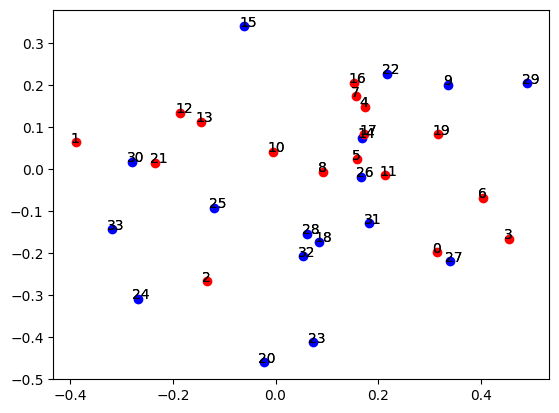

In [16]:
import matplotlib.pyplot as plt

labels = g.ndata['label'] #obtain the labels

embeddings = inputs.detach().numpy()#node_embed.weight.detach().numpy()


for ind,node in enumerate(g.nodes()):  
  if labels[ind] == 0:
    color = 'red'
  else:
    color = 'blue'
    
  '''please draw the embedding using plt.scatter()'''
  plt.scatter(embeddings[ind, 0], embeddings[ind, 1], c=color)
  plt.text(embeddings[ind, 0]-0.01, embeddings[ind, 1], str(int(node.detach().numpy())))

  plt.text(node_embed.weight.detach().numpy()[ind,0]-0.01, node_embed.weight.detach().numpy()[ind,1] , str(int(node.detach().numpy())))
plt.show()

Cluster using kmeans.

/Users/apple/opt/anaconda3/envs/COMP4641/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


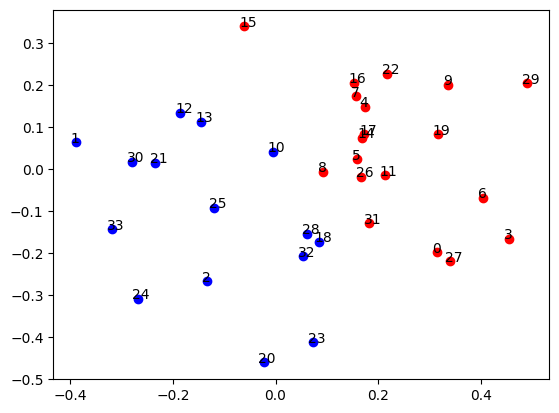

In [17]:
#Import Kmeans,networkx and matplotlib
from sklearn.cluster import KMeans
import networkx as nx
import matplotlib.pyplot as plt

'''please conduct the clustering via sklearn.cluster.Kmeans() function'''
embeddings = node_embed.weight.detach().numpy()

# Cluster using KMeans
kmeans = KMeans(n_clusters=2, random_state=0).fit(embeddings)
pred_labels = kmeans.labels_

#Visualize the embeddings

for ind,node in enumerate(g.nodes()):
  if pred_labels[ind] == 0:
    color = 'red'
  else:
    color = 'blue'
  '''please draw the embedding using plt.scatter()'''
  plt.scatter(embeddings[ind, 0], embeddings[ind, 1], c=color)
  plt.text(node_embed.weight.detach().numpy()[ind,0]-0.01, node_embed.weight.detach().numpy()[ind,1] , str(int(node.detach().numpy())))
plt.show()

**Q3**
Node Classfication


import the Cora dataset

In [18]:
import dgl.data
dataset = dgl.data.CoraGraphDataset()
g = dataset[0]
g_number_of_nodes = g.number_of_nodes()
g_numb_feats = g.ndata['feat'].shape[1]

  NumNodes: 2708
  NumEdges: 10556
  NumFeats: 1433
  NumClasses: 7
  NumTrainingSamples: 140
  NumValidationSamples: 500
  NumTestSamples: 1000
Done loading data from cached files.


Build the model based on  GraphSAGE.


In [19]:
'''please build the model'''
from dgl.nn import SAGEConv

class Model(nn.Module):
    def __init__(self, input_feats, h_feats):
        super(Model, self).__init__()
        '''please build GraphSAGE layer '''
        self.gnn1 = SAGEConv(
            in_feats = input_feats,
            out_feats = h_feats,
            activation = F.relu,
            aggregator_type = 'mean')
            
        
        self.gnn2 = SAGEConv(
            in_feats = h_feats,
            out_feats = h_feats,
            aggregator_type='mean')

    def forward(self, g, in_feat):
        hidden1 = self.gnn1(g, in_feat)
        hidden1_ar = F.relu(hidden1)
        hidden2 = self.gnn2(g, hidden1_ar)
        h = F.relu(hidden2)
        return h

Define the linear classifier

In [20]:
'''please build the classifier'''
class Classifier(nn.Module):
    def __init__(self, h_feat, num_classes):
        super(Classifier, self).__init__()
        '''please build the linear classfier '''
        self.fc1 = nn.Linear( 
            in_features = h_feat,
            out_features = num_classes)

    def forward(self, in_feat):
        h = self.fc1(in_feat)
        return h

In [21]:
input = g.ndata['feat']
print(input)

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


Train the NN.

In [22]:

    h_feats = 16
    num_classes = 7
    input_feats = g.ndata['feat'].shape[1]
    g_number_of_nodes = g.number_of_nodes()
    input = g.ndata['feat']

    import itertools
    '''please complete the functions for the  model'''
    classifier = Classifier(h_feats, num_classes)
    model = Model(input_feats, h_feats)
    optimizer = torch.optim.Adam(
    itertools.chain(model.parameters(), classifier.parameters()), lr=0.01)

    features = g.ndata["feat"]
    labels = g.ndata["label"]
    train_mask = g.ndata["train_mask"]
    val_mask = g.ndata["val_mask"]
    test_mask = g.ndata["test_mask"]

    best_val_acc = 0.0
    best_test_acc = 0.0

    for e in range(100):
        '''please fill in the missing "Forward" and "Compute loss" in training process'''
        # Forward
        hidden = model(g, input)
        logits = classifier(hidden)

        # Compute prediction
        pred = logits.argmax(1)

        # Compute loss
        loss = F.cross_entropy(logits[train_mask], labels[train_mask])

        # Backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Compute accuracy on training/validation/test
        train_acc = (pred[train_mask] == labels[train_mask]).float().mean()
        val_acc = (pred[val_mask] == labels[val_mask]).float().mean()
        test_acc = (pred[test_mask] == labels[test_mask]).float().mean()

        # Save the best validation accuracy and the corresponding test accuracy.
        if best_val_acc < val_acc:
            best_val_acc = val_acc
            best_test_acc = test_acc





        # Compute accuracy on training/validation/test
        train_acc = (pred[train_mask] == labels[train_mask]).float().mean()
        val_acc = (pred[val_mask] == labels[val_mask]).float().mean()
        test_acc = (pred[test_mask] == labels[test_mask]).float().mean()

        print(
                "In epoch {}, loss: {:.3f}, val acc: {:.3f}, test acc: {:.3f}".format(
                    e, loss, val_acc, test_acc
                )
            )

/Users/apple/opt/anaconda3/envs/COMP4641/lib/python3.10/site-packages/dgl/backend/pytorch/tensor.py:445: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  assert input.numel() == input.storage().size(), (


In epoch 0, loss: 1.950, val acc: 0.072, test acc: 0.092
In epoch 1, loss: 1.941, val acc: 0.082, test acc: 0.095
In epoch 2, loss: 1.928, val acc: 0.118, test acc: 0.131
In epoch 3, loss: 1.912, val acc: 0.166, test acc: 0.175
In epoch 4, loss: 1.893, val acc: 0.300, test acc: 0.303
In epoch 5, loss: 1.871, val acc: 0.360, test acc: 0.373
In epoch 6, loss: 1.846, val acc: 0.444, test acc: 0.438
In epoch 7, loss: 1.816, val acc: 0.494, test acc: 0.500
In epoch 8, loss: 1.780, val acc: 0.518, test acc: 0.529
In epoch 9, loss: 1.739, val acc: 0.556, test acc: 0.551
In epoch 10, loss: 1.692, val acc: 0.592, test acc: 0.585
In epoch 11, loss: 1.639, val acc: 0.602, test acc: 0.595
In epoch 12, loss: 1.581, val acc: 0.600, test acc: 0.601
In epoch 13, loss: 1.516, val acc: 0.604, test acc: 0.609
In epoch 14, loss: 1.446, val acc: 0.598, test acc: 0.614
In epoch 15, loss: 1.371, val acc: 0.606, test acc: 0.623
In epoch 16, loss: 1.291, val acc: 0.624, test acc: 0.635
In epoch 17, loss: 1.207